# **Momento de Retroalimentación: Módulo 1 Utilización, procesamiento y visualización de grandes volúmenes de datos (Portafolio Análisis)**

## *Tania Sayuri Guizado Hernández | A01640092*

### 1-. Configura correctamente tu entorno de trabajo en Colab para utilizar PySpark (Preparación del ambiente de trabajo para Big Data en Colab)

En este paso después de hacer la instalación correcta de pyspark py4j, estableci una sesión de Spark a la que llame con mi nombre y se creo una instancia de SparkSession. Al crear esto me permite tener la manipulación y procesamiento de datos con Spark lo cual me servirá para completar el resto de la actividad.

In [ ]:
# Se descargan las librerías necesarias para el resto de la actividad
from pyspark.sql import DataFrame, SparkSession
from pyspark.ml.regression import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml import Pipeline
from pyspark.ml.clustering import GaussianMixture
from sklearn.metrics import confusion_matrix
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

#Se levanta la sesión de Spark
spark = SparkSession \
       .builder \
       .appName("Sayuri") \
       .getOrCreate()

spark

### 2-. Una vez configurado tu ambiente de trabajo selecciona una base de datos que se caracterice por tener un gran volumen de datos.

Las bases de datos que se utilizaran para los modelos inteligentes de regresión, clasificación y agrupamiento fueron sacadas de un [repositorio de github](https://github.com/apache/spark/tree/master/data/mllib)

### 3-. Utilizando MLlib genera un modelo inteligente de clasificación, regresión o agrupamiento con la base de datos que seleccionaste (Generación de modelos inteligentes utilizando PySpark y MLLib)

#### 3.1-. Genera un modelo de regresión utilizando PySpark y MLlib. Para realizar esto ingresa al siguiente [enlace](https://spark.apache.org/docs/latest/ml-classification-regression.html#regression) y selecciona una técnica de las disponibles.


En esta parte del código se va realizar una regresión lineal, al principio se cargan el conjunto de datos de entrenamiento para después definir el modelo de la regresión lineal con parámetros específicos. Una vez que el modelo ya se encuentra ajustados a los datos se imprimirán los coeficientes y la intercepción resultantes. Además, se mostrará el error cuadrático medio y el coeficiente de determinación. En este caso la métrica R-cuadrado es bastante bajo, con un valor de 0.0229, lo que sugiere en mi evaluación que el modelo no se ajusta muy bien a los datos y podría necesitar mejoras.

In [ ]:
# Cargamos los datos de entrenamiento
training = spark.read.format("libsvm")\
    .load("/content/sample_linear_regression_data.txt")

In [ ]:
# Definir el modelo de regresión lineal con ciertos parámetros
lr = LinearRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Ajustar el modelo a los datos de entrenamiento
lrModel = lr.fit(training)

# Imprimir los coeficientes y la intercepción del modelo de regresión lineal
print("Coefficients: %s" % str(lrModel.coefficients))
print("Intercept: %s" % str(lrModel.intercept))

# Resumir el modelo en el conjunto de entrenamiento y mostrar algunas métricas
trainingSummary = lrModel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show()
residuals = trainingSummary.residuals.toPandas()
rmse = trainingSummary.rootMeanSquaredError
r2 = trainingSummary.r2
print("RMSE: %f" % rmse)
print("r2: %f" % r2)

Coefficients: [0.0,0.3229251667740594,-0.3438548034562219,1.915601702345841,0.05288058680386255,0.765962720459771,0.0,-0.15105392669186676,-0.21587930360904645,0.2202536918881343]
Intercept: 0.15989368442397356
numIterations: 6
objectiveHistory: [0.49999999999999994, 0.4967620357443381, 0.49363616643404634, 0.4936351537897608, 0.4936351214177871, 0.49363512062528014, 0.4936351206216114]
+--------------------+
|           residuals|
+--------------------+
|  -9.889232683103197|
|  0.5533794340053553|
|  -5.204019455758822|
| -20.566686715507508|
|    -9.4497405180564|
|  -6.909112502719487|
|  -10.00431602969873|
|  2.0623978070504845|
|  3.1117508432954772|
|  -15.89360822941938|
|  -5.036284254673026|
|  6.4832158769943335|
|  12.429497299109002|
|  -20.32003219007654|
|    -2.0049838218725|
| -17.867901734183793|
|   7.646455887420495|
| -2.2653482182417406|
|-0.10308920436195645|
|  -1.380034070385301|
+--------------------+
only showing top 20 rows

RMSE: 10.189077
r2: 0.022861


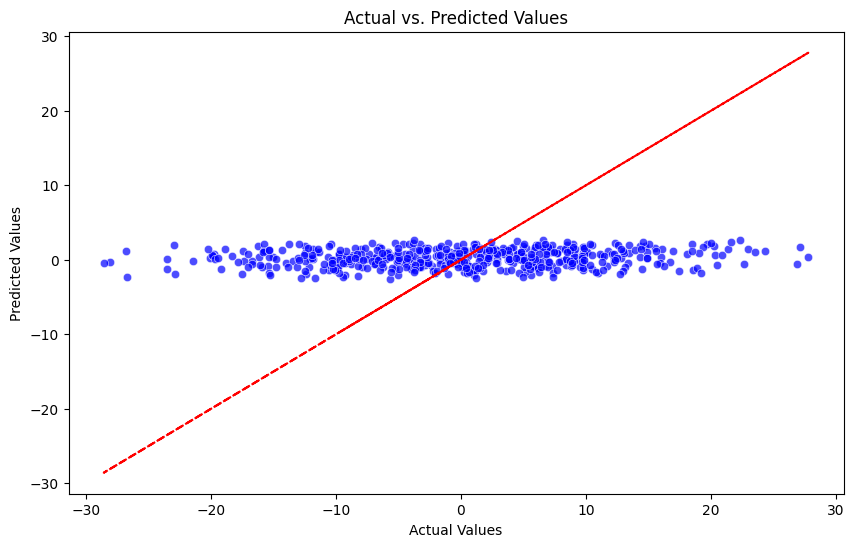

In [ ]:
# Realizar predicciones utilizando el modelo y mostrar un gráfico de dispersión
predictions = lrModel.transform(training).toPandas()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='label', y='prediction', data=predictions, color="b",alpha=0.7)
plt.plot(predictions['label'], predictions['label'], color='r', linestyle='--', label='Regression Line')
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

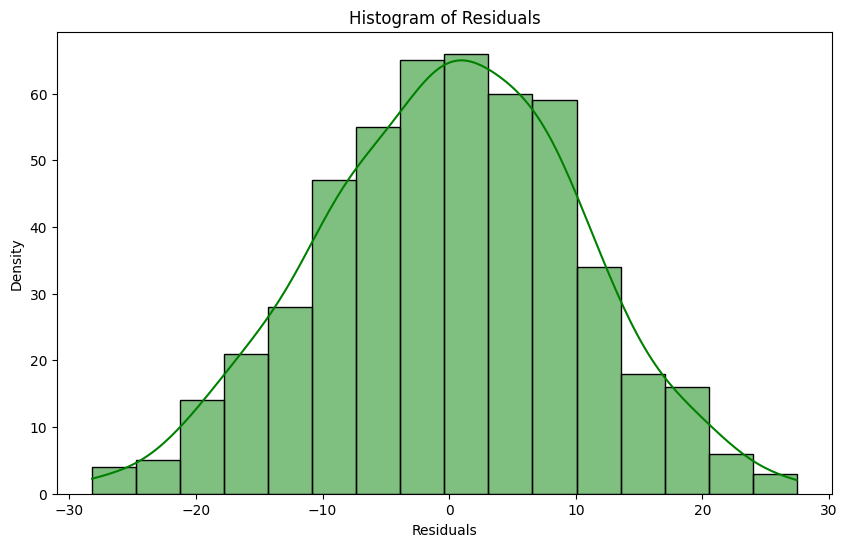

In [ ]:
# Mostrar un histograma de los residuos
plt.figure(figsize=(10, 6))
sns.histplot(residuals['residuals'], kde=True, color="g")
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.show()

#### 3.2 Genera un modelo de clasificación utilizando PySpark y MLlib. Para realizar esto ingresa al siguiente [enlace](https://spark.apache.org/docs/latest/ml-classification-regression.html#classification) y selecciona una técnica de las disponibles.

Lleve a cabo la creación de un modelo de clasificación en PySpark utilizando la técnica de Random Forest Classifier. Yo elegí modelo de clasificación porque maneja bien conjuntos de datos con múltiples características, lidia con alta dimensionalidad y es resistente al sobreajuste. También es capaz de manejar datos categóricos y numéricos, y es útil para evaluar la importancia de las características en la clasificación.

Prosiguiendo con la actividad cargue los datos y realice indexaciones tanto en las etiquetas como en las características con el fin de preparar los datos para después hacer la división del conjunto de datos en conjuntos de entrenamiento y prueba. A continuación, el modelo RandomForest Classifier se entrenó utilizando el conjunto de entrenamiento, y se efectuaron predicciones en el conjunto de prueba mediante transformadores. La precisión del modelo se evaluó empleando la métrica de clasificación multiclase, y se proporcionó una representación visual de la eficacia del modelo a través de una matriz de confusión. Además, se implementó un modelo de mezcla de Gaussianas en un conjunto de datos diferente, seguido de la visualización de la distribución de muestras en los clústeres generados por el modelo.

In [ ]:
# Cargar y analizar el archivo de datos, convirtiéndolo en un DataFrame.
data = spark.read.format("libsvm").load("/content/sample_libsvm_data.txt")

In [ ]:
# Indexar las etiquetas, agregando metadatos a la columna de etiquetas.
# Ajustar en todo el conjunto de datos para incluir todas las etiquetas en el índice.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(data)

# Identificar automáticamente las características categóricas e indexarlas.
# Establecer maxCategories para que las características con > 4 valores distintos se traten como continuas.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

# Dividir los datos en conjuntos de entrenamiento y prueba (30% para pruebas)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Entrenar el modelo de RandomForest.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Convertir las etiquetas indexadas de vuelta a las etiquetas originales.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Encadenar los indexadores y el forest en un Pipeline.
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Entrenar el modelo. Esto también ejecuta los indexadores.
model = pipeline.fit(trainingData)

# Realizar predicciones.
predictions = model.transform(testData)

# Seleccionar ejemplos para mostrar.
predictions.select("predictedLabel", "label", "features").show(5)

# Seleccionar (predicción, etiqueta real) y calcular el error de prueba.
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

# Obtener el modelo de Random Forest y mostrar un resumen.
rfModel = model.stages[2]
print(rfModel)  # summary only

+--------------+-----+--------------------+
|predictedLabel|label|            features|
+--------------+-----+--------------------+
|           0.0|  0.0|(692,[100,101,102...|
|           0.0|  0.0|(692,[123,124,125...|
|           0.0|  0.0|(692,[124,125,126...|
|           0.0|  0.0|(692,[126,127,128...|
|           0.0|  0.0|(692,[126,127,128...|
+--------------+-----+--------------------+
only showing top 5 rows

Test Error = 0
RandomForestClassificationModel: uid=RandomForestClassifier_c6b2d276e4f9, numTrees=10, numClasses=2, numFeatures=692


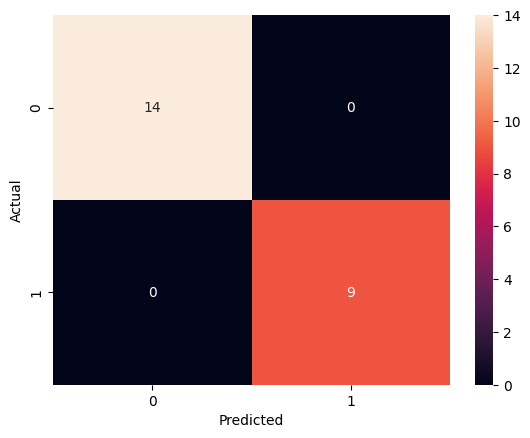

In [ ]:
y_true = predictions.select("indexedLabel").toPandas()
y_pred = predictions.select("prediction").toPandas()

# Crear y mostrar una matriz de confusión
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
# Cargar el conjunto de datos
dataset = spark.read.format("libsvm").load("/content/sample_kmeans_data.txt")

# # Crear un modelo de mezcla de Gaussianas con 2 componentes y una semilla para la reproducibilidad
gmm = GaussianMixture().setK(2).setSeed(538009335)
model = gmm.fit(dataset)

# Imprimir las Gaussianas como un DataFrame
print("Gaussians shown as a DataFrame: ")
model.gaussiansDF.show(truncate=False)

Gaussians shown as a DataFrame: 
+-------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|mean                                                         |cov                                                                                                                                                                                                       |
+-------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|[0.10000000000001552,0.10000000000001552,0.10000000000001552]|0.006666666666806454  0.006666666666806454  0.006666666666806454  \n0.006666666666806454  0.00666666666

In [ ]:
# Imprimir el esquema del conjunto de datos
dataset.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)



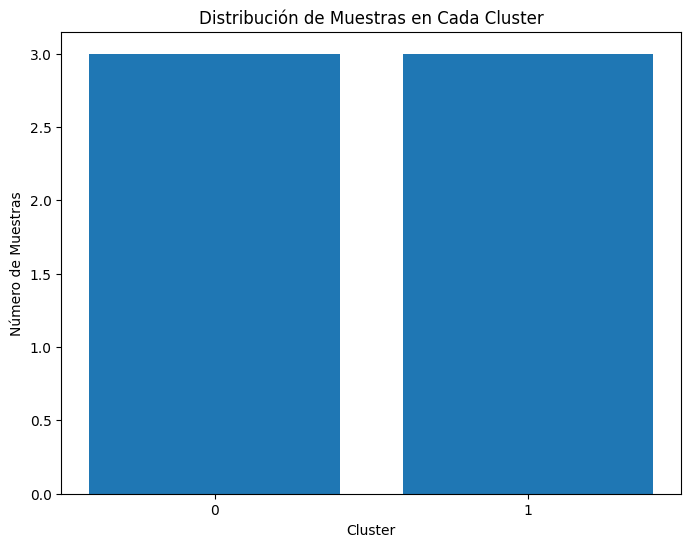

In [ ]:
# Realizar predicciones en el conjunto de datos y seleccionar la columna "prediction"
results = model.transform(dataset).select("prediction").rdd.map(lambda x: x[0])

## Crear un histograma de los resultados para visualizar la distribución de muestras en cada cluster
plt.figure(figsize=(8, 6))
plt.hist(results.collect(), bins=range(3), align='left', rwidth=0.8)
plt.title('Distribución de Muestras en Cada Cluster')
plt.xlabel('Cluster')
plt.ylabel('Número de Muestras')
plt.xticks(range(2))
plt.show()